In [18]:
import pandas as pd
import numpy as np

df = pd.read_csv('C:/Users/kaczm/project_git/Bidding-CPM-Prediction/dataset/cpm_prediction.csv')

In [20]:
# first let's start off with XGBoost, then let's try RF

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y = df['CPM']
X = df.drop(columns = ['CPM'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

def XGBoost_model(X_train, y_train, X_test, y_test):
    model = XGBRegressor(objective='reg:squarederror', random_state=42) # I will be tuning the parameters on the go
    model.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = model.predict(X_test)
    
    # Printing metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    
    return model

In [21]:
xgb_model = XGBoost_model(X_train, y_train, X_test, y_test)

Root Mean Squared Error: 143.24679325604657
Mean Absolute Error: 7.046851970078372


site_id : 0.08532096
ad_type_id : 0.013586768
geo_id : 0.0024225444
device_category_id : 0.018806277
advertiser_id : 9.264672e-05
os_id : 0.0021213458
integration_type_id : 0.0
monetization_channel_id : 4.681785e-05
ad_unit_id : 0.00243911
total_impressions : 0.1638682
total_revenue : 0.56109905
viewable_impressions : 0.0019154042
measurable_impressions : 0.13542004
revenue_share_percent : 0.0
measurable_to_total_imps : 0.00042235214
viewable_to_total_imps : 0.01166986
actual_revenue : 0.0
week : 0.0007685777
month : 0.0


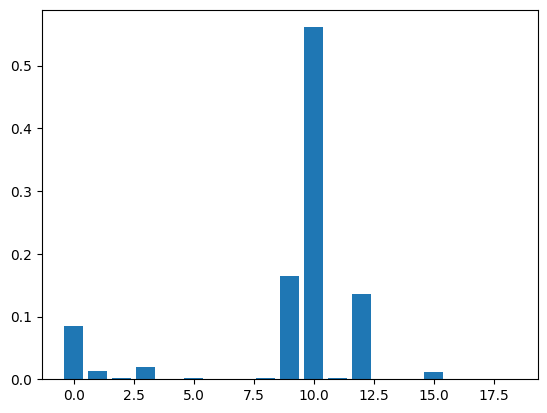

In [22]:
# lets check out this model
import matplotlib.pyplot as plt 

# Feature importance
importance = xgb_model.feature_importances_
for i,j in enumerate(importance):
    print(X_train.columns[i],":", j)

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [23]:
# total revenue has a very strong effect on the model - let's see correlations


correlations = df.corr()['CPM'].sort_values(ascending=False)
print(correlations)

CPM                         1.000000
total_revenue               0.084538
actual_revenue              0.084538
ad_type_id                  0.061719
geo_id                      0.056828
viewable_to_total_imps      0.040822
ad_unit_id                  0.027816
viewable_impressions        0.009622
total_impressions           0.000674
measurable_impressions      0.000615
measurable_to_total_imps   -0.003742
week                       -0.006392
site_id                    -0.009248
advertiser_id              -0.016978
os_id                      -0.023717
device_category_id         -0.024757
monetization_channel_id    -0.028133
integration_type_id              NaN
revenue_share_percent            NaN
month                            NaN
Name: CPM, dtype: float64


In [24]:
# now let's do some random forest

from sklearn.ensemble import RandomForestRegressor

def RandomForest_model(X_train, y_train, X_test, y_test, n_estimators=100, random_state=42):
    # Initialize the model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    
    # fit the model
    model.fit(X_train, y_train)

    # predicting the Test set results
    y_pred = model.predict(X_test)
    
    # printing metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    
    return model

# Use the function to train the model and get predictions
rf_model = RandomForest_model(X_train, y_train, X_test, y_test)

# very interesting - seems like this model generalizes better, but occassionaly makes bigger mistakes than XGBoost 

Root Mean Squared Error: 420.80157725409407
Mean Absolute Error: 5.23230364917595


In [25]:
# I want to investigate a little why this model makes those large mistakes

def large_errors_rf(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Create a DataFrame from the test data
    df_test = pd.DataFrame(X_test)

    # Add the actual and predicted values to the DataFrame
    df_test['Actual'] = y_test
    df_test['Predicted'] = y_pred

    # Calculate the absolute error
    df_test['Error'] = abs(df_test['Actual'] - df_test['Predicted'])

    # now inspect the rows where the error is large
    # This will show us the top 10 instances where the model's predictions had the largest errors
    large_errors = df_test.sort_values('Error', ascending=False).head(10)

    print(large_errors)

    return large_errors

x = large_errors_rf(rf_model, X_test, y_test)

# advertiser_id, integration_type_id and monetization_channel_id are all the same for those errors

        site_id  ad_type_id  geo_id  device_category_id  advertiser_id  os_id  \
193526      342          10     143                   1             79     56   
124876      349          10     187                   1             79     56   
189730      346          10      11                   3             79     55   
210465      342          10      33                   1             79     56   
21705       346          10     129                   1             79     56   
159507      351          10     187                   2             79     58   
77435       346          10     168                   3             79     55   
220119      350          10      33                   1             79     56   
44862       350          10      33                   3             79     59   
160595      349          10     187                   2             79     60   

        integration_type_id  monetization_channel_id  ad_unit_id  \
193526                    1             

In [26]:
# I will also try linear regression 

from sklearn.linear_model import LinearRegression
def train_linear_regression(X_train, y_train, X_test, y_test):
    # initialize the Linear Regression model
    model = LinearRegression()

    # train the model
    model.fit(X_train, y_train)

    # use the model to predict the test set
    y_pred = model.predict(X_test)
    
    # calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    
    return model

# call the function
lr_model = train_linear_regression(X_train, y_train, X_test, y_test)

# LR is evidently now the way to go

Root Mean Squared Error: 869.8809332746004
Mean Absolute Error: 219.56607098803852


In [ ]:
# I kindaa want to do some NN as well just to see how they perform for this task

